In [47]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import timedelta



In [48]:
df = pd.read_csv('data/cleaned_covid_data.csv')
df.head()

,iso_code,continent,location,date,total_cases,total_deaths,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,population,Month_year
0,AFG,Asia,Afghanistan,2020-01-05,0,0,0,0,0,0,41128772,2020-01
1,AFG,Asia,Afghanistan,2020-01-06,0,0,0,0,0,0,41128772,2020-01
2,AFG,Asia,Afghanistan,2020-01-07,0,0,0,0,0,0,41128772,2020-01
3,AFG,Asia,Afghanistan,2020-01-08,0,0,0,0,0,0,41128772,2020-01
4,AFG,Asia,Afghanistan,2020-01-09,0,0,0,0,0,0,41128772,2020-01


<Axes: xlabel='Month_year'>

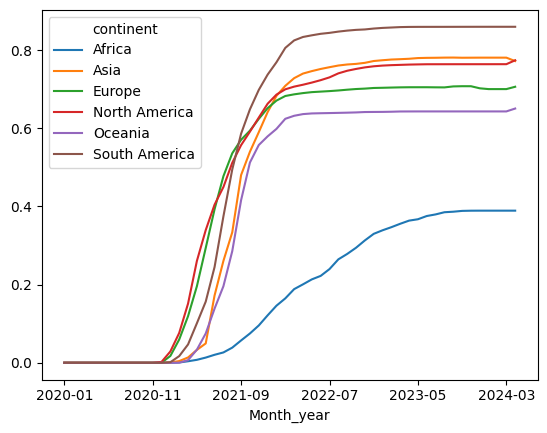

In [49]:
# First let's look at the total number of people vaccinated per month
people_vacinated = df.groupby(['Month_year', 'continent'])['people_vaccinated'].sum().unstack()/df.groupby(['Month_year', 'continent'])['population'].sum().unstack()
people_vacinated.plot(kind='line')

For the interest of case I'll forecst vaccination for the 3 months since september 2021

<Axes: xlabel='date'>

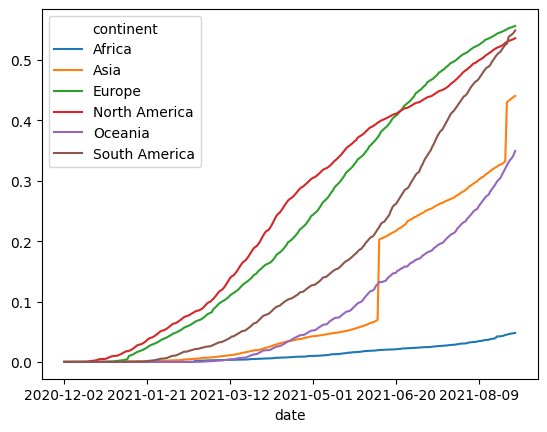

In [50]:
df_grouped = df[(df['date']<'2021-09-01')&(df['date']>'2020-12-01')].groupby(['date', 'continent'])[['people_vaccinated', 'population']].sum()
df_grouped['vaccination_rate'] = df_grouped['people_vaccinated']/df_grouped['population']
df_grouped['vaccination_rate'].unstack().plot(kind='line')

Vacinations rate is a sigmoidal function as the number of people vaccinated increases, the rate of vaccination decreases. This is because the number of people who are willing to get vaccinated decreases as the number of people vaccinated increases. This is a common trend in vaccination campaigns. The maximum possible value to reach is 1 but in most of the cases it never happens.

In [51]:
from helpers import forecast_vaccination_rates_sigma

df_grouped_vaccinated = df_grouped.unstack()['vaccination_rate']
df_grouped_vaccinated.reset_index(inplace=True)
df_grouped_vaccinated['date'] = pd.to_datetime(df_grouped_vaccinated['date'])

continents = df_grouped_vaccinated.columns[1:]

forecasts = {}
upper_forecasts = {}
lower_forecasts = {}

X = np.array(df_grouped_vaccinated.index).reshape(-1, 1) 
dates = df_grouped_vaccinated.date
dates = list(map(lambda d: d.date(), dates))
max_x = max(X)[0]

#All guesses are done manually looking at the data plot 
initial_guesses = {
    'Europe': [0.9, 0.5, 240],
    'Africa': [0.5, 0.3, 340],
    'Asia': [0.7, 0.5, 250],
    'North America': [0.9, 0.5, 250],
    'South America': [0.8, 0.5, 280],
    'Oceania': [0.6, 1, 220]
}

for continent in continents:
    y = df_grouped_vaccinated[continent].values.reshape(-1, 1)
    initial_guess = initial_guesses[continent]
    future_indexes, forecast, upper_forecast, lower_forecast = forecast_vaccination_rates_sigma(X, y,initial_guess)
    adjustment_value = y[-1] - forecast[max_x - 1]
    # sigmoid function is not perfect, it's fitting values to decrease error,
    # so the prediction value can be actually smaller than the real value due to unpredicted jumps in the data 
    # or adjustments of data keeper.
    # so we need to adjust the forecast to match the last value as our value should not go down
    forecast = forecast + adjustment_value
    # Same for confidence intervals 
    upper_forecast = upper_forecast + adjustment_value
    lower_forecast = lower_forecast + adjustment_value 

    forecasts[continent] = forecast.ravel() 
    upper_forecasts[continent] = upper_forecast.ravel()
    lower_forecasts[continent] = lower_forecast.ravel()

max_index = df_grouped_vaccinated.index.max()
future_indexes_readable = range(max_index + 90) 

forecast_df = pd.DataFrame(forecasts, index=future_indexes_readable)
upper_ft_df = pd.DataFrame(upper_forecasts, index=future_indexes_readable)
lower_ft_df = pd.DataFrame(lower_forecasts, index=future_indexes_readable)
forecast_df

/Users/veronika.shmagina/Downloads/covid_project/helpers.py:7: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


,Africa,Asia,Europe,North America,Oceania,South America
0,0.004943,0.087823,0.017572,0.051099,0.030860,0.006485
1,0.004955,0.087827,0.017834,0.051445,0.030893,0.006597
2,0.004967,0.087831,0.018101,0.051799,0.030928,0.006712
3,0.004979,0.087835,0.018375,0.052162,0.030963,0.006829
4,0.004992,0.087840,0.018656,0.052535,0.031000,0.006948
...,...,...,...,...,...,...
357,0.068944,0.461107,0.592558,0.549275,0.444703,0.707843
358,0.069086,0.461134,0.592690,0.549316,0.445102,0.708628
359,0.069226,0.461159,0.592818,0.549356,0.445491,0.709397
360,0.069363,0.461183,0.592944,0.549395,0.445872,0.710151


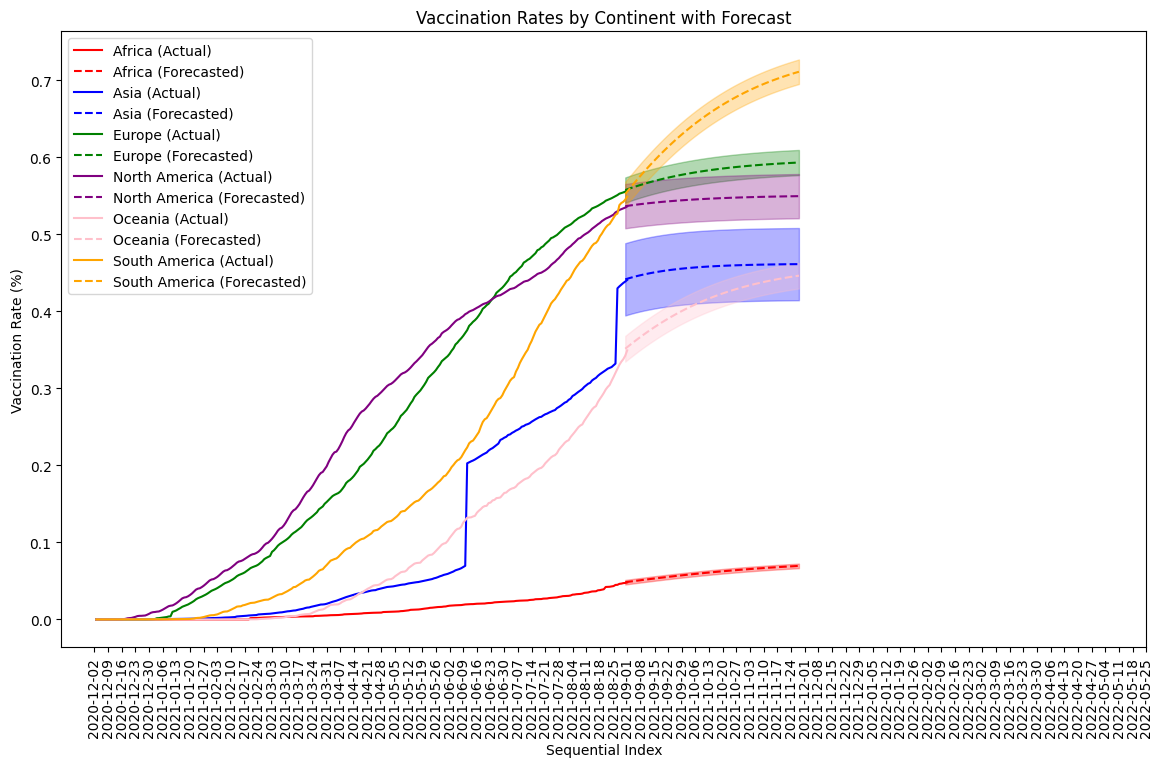

In [54]:
plt.figure(figsize=(14, 8))

colors = {
    'Asia': 'blue',
    'Europe': 'green',
    'Africa': 'red',
    'North America': 'purple',
    'South America': 'orange',
    'Australia': 'brown',
    'Oceania': 'pink'
}

for continent in continents:
    continent_color = colors[continent]

    actual_data = df_grouped_vaccinated[continent].fillna(0)

    actual_indices = range(1, len(actual_data) + 1)

    #actual values
    plt.plot(actual_indices, actual_data, 
             label=f'{continent} (Actual)', color=continent_color)
    
    #Forecasted full line
    plt.plot(forecast_df.index[max_x:], forecast_df[continent].values[max_x:], linestyle='--', label=f'{continent} (Forecasted)', color=continent_color)

    #Confidence inteval
    plt.fill_between(upper_ft_df.index[max_x:], upper_ft_df[continent].values[max_x:], lower_ft_df[continent].values[max_x:], color=continent_color, alpha=0.3)

plt.xlabel('Sequential Index')
plt.ylabel('Vaccination Rate (%)')

# Replacement of integers ticks with dates
# Extend dates with extra 2 months
last_date = dates[-1]
extra_dates = [last_date + timedelta(days=x) for x in range(1, 91)]
dates += extra_dates

plt.xticks(ticks=range(0, len(dates), 7), labels=dates[::7], rotation=90)

plt.title('Vaccination Rates by Continent with Forecast')
plt.legend(loc='upper left')
plt.savefig('plots/vaccination_rates_forecast.png')
plt.show()
